In [15]:
# # ONLY RUN THIS IF YOU'RE IN GOOGLE COLAB
# from google.colab import drive
# import os

# drive.mount('/content/drive')
# os.chdir('/content/drive/MyDrive/Thesis/Pintu-Air')

# # Verify you're in the right place
# !pwd
# !ls -la

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.stats.diagnostic import acorr_ljungbox, lilliefors
from scipy import stats
from scipy.stats import boxcox, boxcox_normmax, boxcox_llf, chi2
import statsmodels.api as sm
from statsmodels.tsa.statespace.varmax import VARMAX

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [17]:
def read_data():
    # Read full dataset
    df = pd.read_csv("03 Result Data Cleaning Part 3.csv")
    df['Tanggal'] = pd.to_datetime(df['Tanggal'])
    df = df.set_index('Tanggal')
    print(f"{'='*60}\nFull Dataset Information:\n{'='*60}")
    print(df.info())
    
    # Read selected pintu air data (Y variables - water levels)
    data_y = df[['Katulampa (air)', 'Depok (air)', 'Manggarai (air)', 'Karet (air)']].copy()
    print(f"\n{'='*60}\nY Data (Water Levels) Sample:\n{'='*60}")
    print(data_y.head())
    
    # Read weather data (X variables - weather conditions)  
    data_x = df[['Katulampa (cuaca)', 'Depok (cuaca)', 'Manggarai (cuaca)', 'Karet (cuaca)']].copy()
    print(f"\n{'='*60}\nX Data (Weather Conditions) Sample:\n{'='*60}")
    print(data_x.head())
    
    # Check unique weather conditions
    print(f"\n{'='*60}\nUnique Weather Conditions per Location:\n{'='*60}")
    for col in data_x.columns:
        unique_values = data_x[col].unique()
        print(f"{col}: {unique_values}")
    
    # Separate train and test data (95% train, 5% test)
    split_index = int(len(data_y) * 0.95)
    
    # Split Y data
    data_y_train = data_y[:split_index]
    data_y_test = data_y[split_index:]
    
    # Split X data and apply one-hot encoding
    data_x_train = pd.get_dummies(data_x[:split_index], drop_first=False)
    data_x_test = pd.get_dummies(data_x[split_index:], drop_first=False)

    # Drop 'Terang' column as specified
    drop_column = 'Terang'

    # Find columns that end with 'Terang'
    terang_columns = [col for col in data_x_train.columns if col.endswith('Terang')]
    
    data_x_train = data_x_train.drop(columns=terang_columns, errors='ignore')
    data_x_test = data_x_test.drop(columns=terang_columns, errors='ignore')
    
    # Ensure test set has same columns as train set
    data_x_test = data_x_test.reindex(columns=data_x_train.columns, fill_value=0)
    
    # Print data distribution information
    print(f"\n{'='*60}\nData Train and Test Distribution:\n{'='*60}")
    print(f'Jumlah data total: {len(data_y)}')
    print(f'Jumlah data train: {len(data_y_train)} ({len(data_y_train)/len(data_y)*100:.1f}%)')
    print(f'Jumlah data test: {len(data_y_test)} ({len(data_y_test)/len(data_y)*100:.1f}%)')
    
    return data_x_train, data_x_test, data_y_train, data_y_test

In [18]:
data_x_train, data_x_test, data_y_train, data_y_test = read_data()

Full Dataset Information:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 31224 entries, 2021-10-16 00:00:00 to 2025-05-08 23:00:00
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ID_Raw                31196 non-null  float64
 1   ID_Cleaned            31224 non-null  int64  
 2   Katulampa (air)       31224 non-null  float64
 3   Katulampa (cuaca)     31224 non-null  object 
 4   Depok (air)           31224 non-null  float64
 5   Depok (cuaca)         31224 non-null  object 
 6   Manggarai (air)       31224 non-null  float64
 7   Manggarai (cuaca)     31224 non-null  object 
 8   Karet (air)           31224 non-null  float64
 9   Karet (cuaca)         31224 non-null  object 
 10  Krukut (air)          31224 non-null  float64
 11  Krukut (cuaca)        31224 non-null  object 
 12  Pesanggrahan (air)    31224 non-null  float64
 13  Pesanggrahan (cuaca)  31224 non-null  object 
 14  Angke (ai

In [19]:
data_y_train.head()

,Katulampa (air),Depok (air),Manggarai (air),Karet (air)
Tanggal,,,,
2021-10-16 00:00:00,10.0,80.0,555.0,25.0
2021-10-16 01:00:00,10.0,95.0,555.0,250.0
2021-10-16 02:00:00,10.0,95.0,555.0,250.0
2021-10-16 03:00:00,10.0,90.0,555.0,250.0
2021-10-16 04:00:00,10.0,90.0,560.0,250.0


In [20]:
data_x_train.head()

,Katulampa (cuaca)_Gerimis,Katulampa (cuaca)_Hujan,Katulampa (cuaca)_Mendung,Katulampa (cuaca)_Mendung Tipis,Depok (cuaca)_Gerimis,Depok (cuaca)_Hujan,Depok (cuaca)_Mendung,Depok (cuaca)_Mendung Tipis,Manggarai (cuaca)_Gerimis,Manggarai (cuaca)_Hujan,Manggarai (cuaca)_Mendung,Manggarai (cuaca)_Mendung Tipis,Karet (cuaca)_Gerimis,Karet (cuaca)_Hujan,Karet (cuaca)_Mendung,Karet (cuaca)_Mendung Tipis
Tanggal,,,,,,,,,,,,,,,,
2021-10-16 00:00:00,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
2021-10-16 01:00:00,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
2021-10-16 02:00:00,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
2021-10-16 03:00:00,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
2021-10-16 04:00:00,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False


# EDA

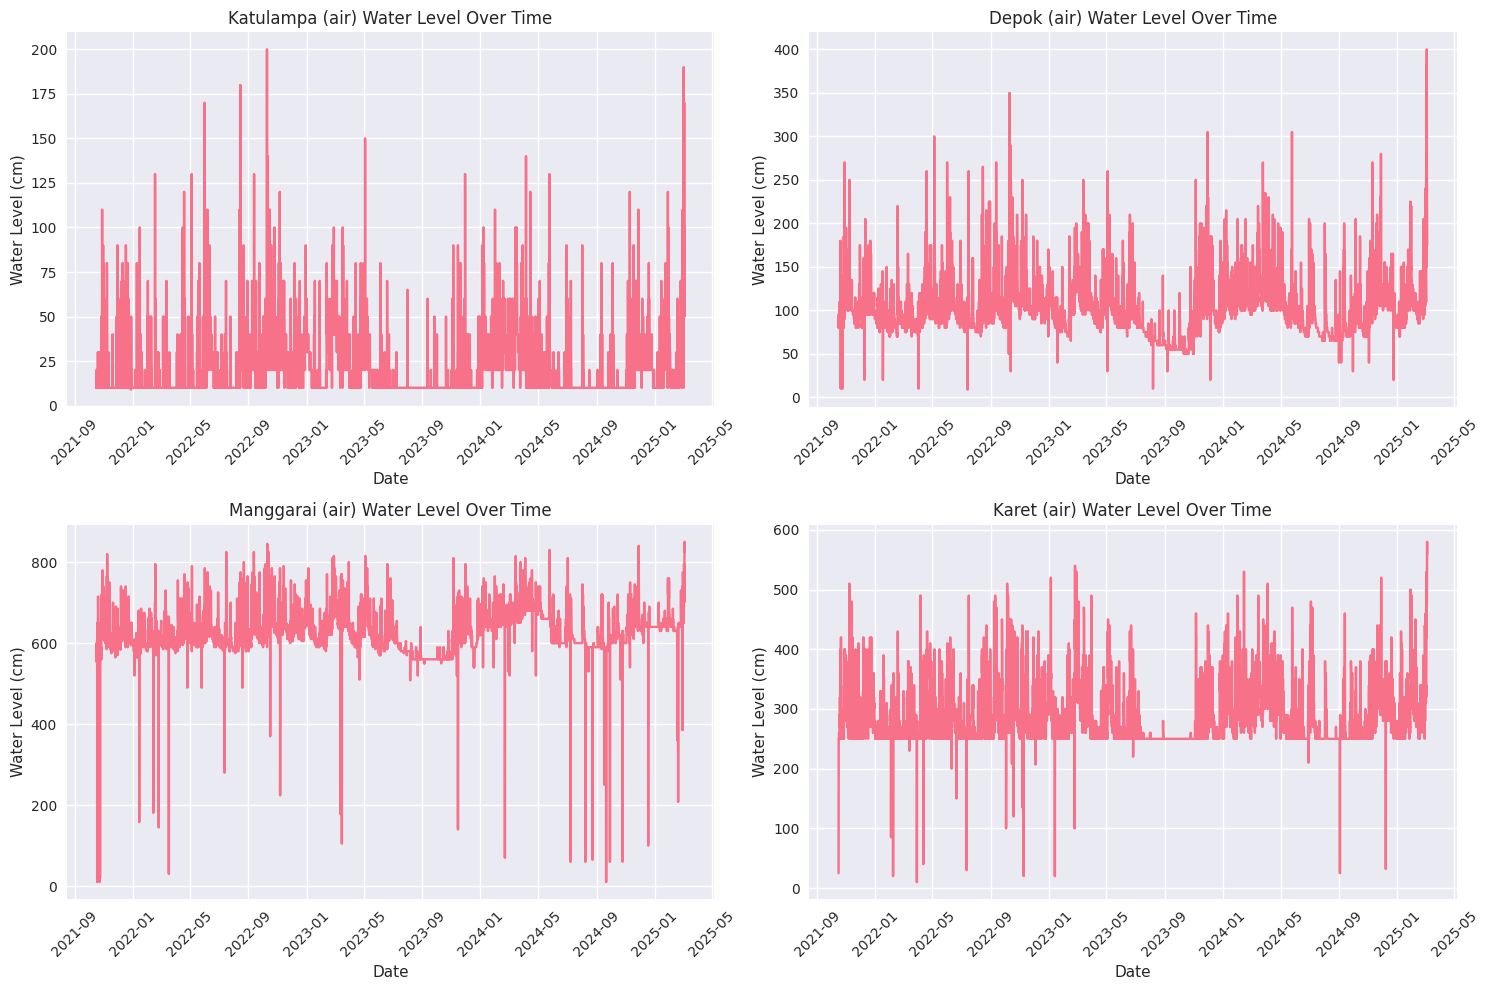

In [21]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

for i, gate in enumerate(data_y_train.columns):
    axes[i].plot(data_y_train.index, data_y_train[gate])
    axes[i].set_title(f'{gate} Water Level Over Time')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Water Level (cm)')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

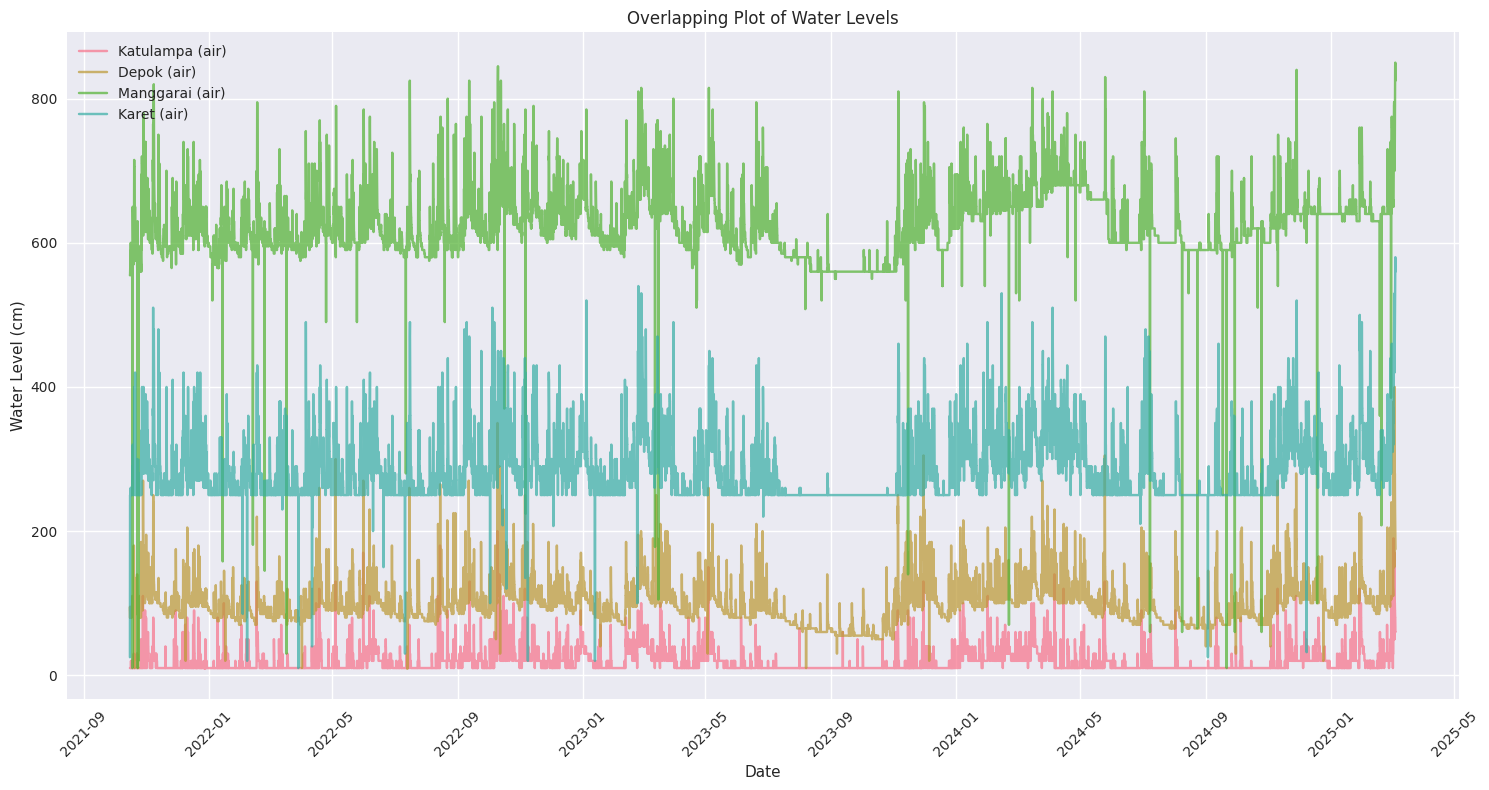

In [22]:
# Plot recent data (last 1000 points for better visibility)
plt.figure(figsize=(15, 8))

for gate in data_y_train.columns:
    plt.plot(data_y_train.index, data_y_train[gate], label=gate, alpha=0.7)
plt.title('Overlapping Plot of Water Levels')
plt.xlabel('Date')
plt.ylabel('Water Level (cm)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

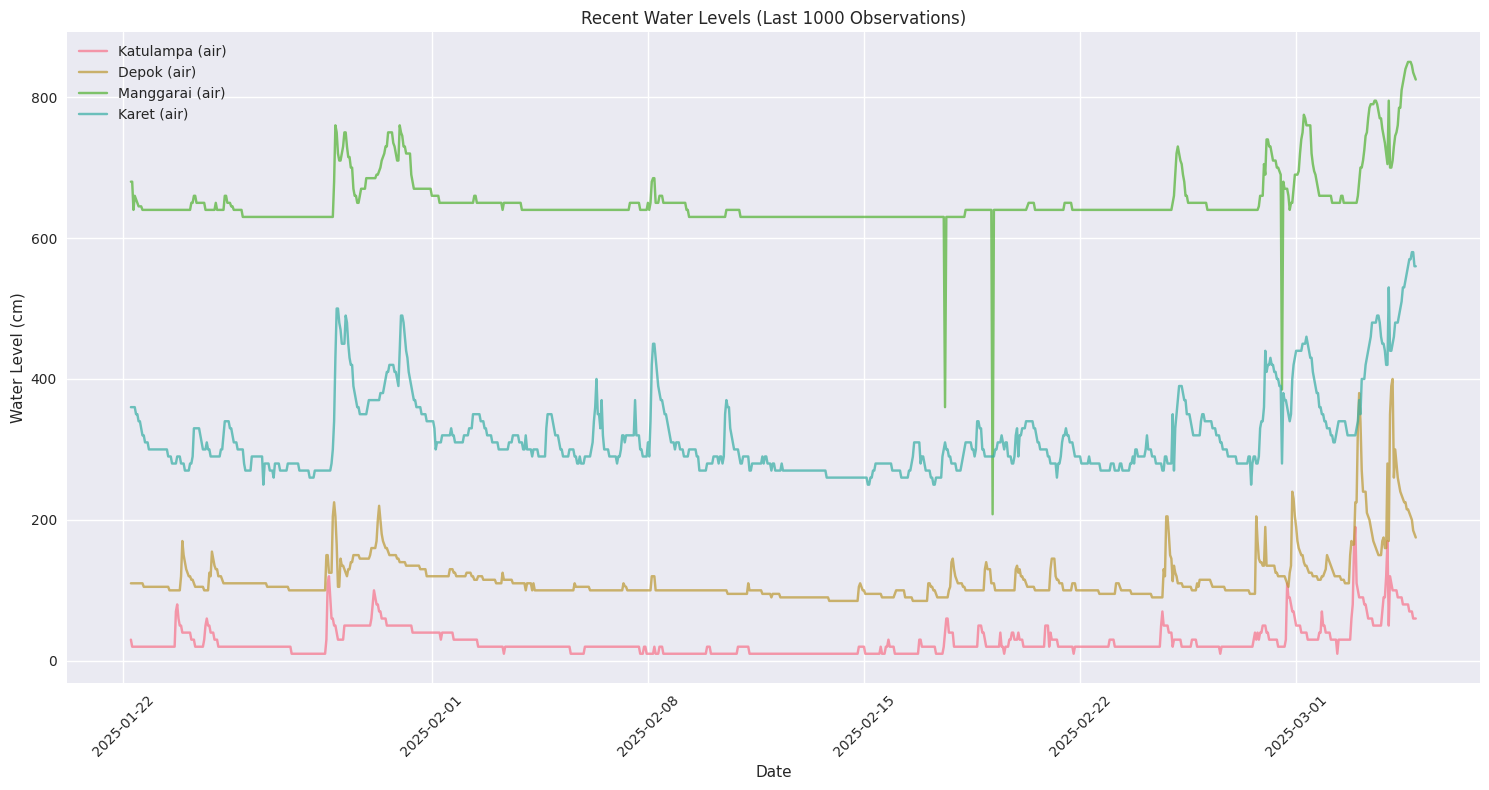

In [23]:
# Plot recent data (last 1000 points for better visibility)
plt.figure(figsize=(15, 8))
recent_data = data_y_train.tail(1000)
for gate in data_y_train.columns:
    plt.plot(recent_data.index, recent_data[gate], label=gate, alpha=0.7)
plt.title('Recent Water Levels (Last 1000 Observations)')
plt.xlabel('Date')
plt.ylabel('Water Level (cm)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

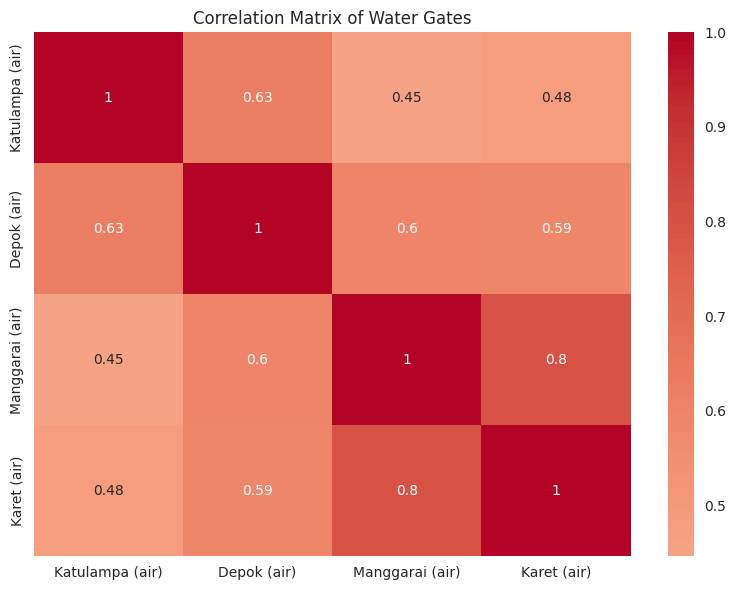

In [24]:
# Correlation heatmap
plt.figure(figsize=(8, 6))
correlation_matrix = data_y_train.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Water Gates')
plt.tight_layout()
plt.show()

# Check Stationarity

## Stationarity to the Variance

In [25]:
def boxcox_transformation(data):
    # Calculate optimum lambda
    lambda_opt = boxcox_normmax(data, method='mle')

    # Log-likelihood with optimum lambda
    llf_opt = boxcox_llf(lambda_opt, data)

    # Log-likelihood if lambda = 1
    llf_null = boxcox_llf(1.0, data)

    # Calculate LRT
    lrt_stat = 2 * (llf_opt - llf_null)

    # Calculate p-value (df = 1)
    p_value = chi2.sf(lrt_stat, df=1)

    print(f"Lambda optimal: {lambda_opt:.4f}")
    print(f"LRT statistic: {lrt_stat:.4f}")
    print(f"P-value: {p_value:.6f}")

    return lambda_opt

def inverse_transform(transformed_data, lambda_opt):
    if lambda_opt == 0:
        return np.exp(transformed_data)  # Log case: e^(transformed_data)
    elif lambda_opt == 1:
        return transformed_data  # No transformation case
    else:
        return np.power(transformed_data, 1/lambda_opt)

In [26]:
lambda_opt = {}
data_y_train_pow = data_y_train.copy()
for pintu_air in data_y_train.columns:
    print(f"{'='*60}\nPower Transform (BoxCox) {pintu_air}:\n{'='*60}")
    print("BEFORE TRANSFORMATION")
    lambda_opt[pintu_air] = boxcox_transformation(data_y_train[pintu_air])
    data_y_train_pow[pintu_air] = data_y_train[pintu_air] ** lambda_opt[pintu_air]
    print("AFTER TRANSFORMATION")
    result = boxcox_transformation(data_y_train_pow[pintu_air])



Power Transform (BoxCox) Katulampa (air):
BEFORE TRANSFORMATION
Lambda optimal: -1.3925
LRT statistic: 37668.5313
P-value: 0.000000
AFTER TRANSFORMATION
Lambda optimal: 1.0000
LRT statistic: 0.0000
P-value: 0.999996
Power Transform (BoxCox) Depok (air):
BEFORE TRANSFORMATION
Lambda optimal: -0.0648
LRT statistic: 5780.4738
P-value: 0.000000
AFTER TRANSFORMATION
Lambda optimal: 1.0000
LRT statistic: 0.0000
P-value: 0.999991
Power Transform (BoxCox) Manggarai (air):
BEFORE TRANSFORMATION
Lambda optimal: 1.3867
LRT statistic: 392.5892
P-value: 0.000000
AFTER TRANSFORMATION
Lambda optimal: 1.0000
LRT statistic: 0.0000
P-value: 0.999994
Power Transform (BoxCox) Karet (air):
BEFORE TRANSFORMATION
Lambda optimal: 0.1231
LRT statistic: 3733.8257
P-value: 0.000000
AFTER TRANSFORMATION
Lambda optimal: 1.0000
LRT statistic: 0.0000
P-value: 0.999991


In [27]:
for pintu_air in data_y_train.columns:
    print(f"{'='*60}\nADF Test {pintu_air}:\n{'='*60}")
    
    adf_result = adfuller(data_y_train_pow[pintu_air])

    # Hasil ADF test
    print(f"ADF Statistic : {adf_result[0]}")
    print(f"p-value       : {adf_result[1]}")
    print("Critical Values:")
    for key, value in adf_result[4].items():
        print(f"   {key} : {value}")

ADF Test Katulampa (air):
ADF Statistic : -8.098528274191054
p-value       : 1.3189154107972505e-12
Critical Values:
   1% : -3.4305708593757225
   5% : -2.86163761382706
   10% : -2.5668219568695214
ADF Test Depok (air):
ADF Statistic : -6.259897951263752
p-value       : 4.2484977028088276e-08
Critical Values:
   1% : -3.4305708295423916
   5% : -2.861637600642031
   10% : -2.5668219498514464
ADF Test Manggarai (air):
ADF Statistic : -8.929164271833162
p-value       : 9.922751729042287e-15
Critical Values:
   1% : -3.4305708146287484
   5% : -2.861637594050852
   10% : -2.56682194634312
ADF Test Karet (air):
ADF Statistic : -11.017475045022644
p-value       : 6.105071069053156e-20
Critical Values:
   1% : -3.4305708146287484
   5% : -2.861637594050852
   10% : -2.56682194634312


# Granger Causality

H0: Variable X does NOT Granger-cause variable Y

H1: Variable X DOES Granger-cause variable Y

In [28]:
variables = data_y_train_pow.columns.tolist()
causality_matrix = pd.DataFrame(index=variables, columns=variables)

In [35]:
significant_causalities = []
max_lag = 5
alpha = 0.05

# Test all pairs
for cause_var in variables:
    for effect_var in variables:
        if cause_var != effect_var:  # Don't test variable against itself
            print(f"\nTesting: Does '{cause_var}' Granger-cause '{effect_var}'?")
            
            test_data = data_y_train_pow[[effect_var, cause_var]].dropna()

            try:
                # Perform Granger causality test
                result = grangercausalitytests(test_data, maxlag=max_lag, verbose=False)
                
                # Extract p-values for different lags
                p_values = []
                for lag in range(1, max_lag + 1):
                    if lag in result:
                        p_value = result[lag][0]['ssr_ftest'][1]
                        p_values.append(p_value)
                
                # Find the best lag (minimum p-value)
                if p_values:
                    min_p_value = min(p_values)
                    best_lag = p_values.index(min_p_value) + 1
                    
                    # Store in matrix
                    causality_matrix.loc[cause_var, effect_var] = min_p_value
                    
                    # Check significance
                    significance = "YES" if min_p_value < alpha else "NO"
                    print(f"  Best lag: {best_lag}, p-value: {min_p_value:.6f}, Significant: {significance}")
                    
                    if min_p_value < alpha:
                        significant_causalities.append({
                            'cause': cause_var,
                            'effect': effect_var,
                            'p_value': min_p_value,
                            'best_lag': best_lag
                        })
                        print(f"  → '{cause_var}' DOES Granger-cause '{effect_var}' at {best_lag} lags")
                    else:
                        print(f"  → '{cause_var}' does NOT Granger-cause '{effect_var}'")
            
            except Exception as e:
                print(f"  Error testing {cause_var} → {effect_var}: {e}")
                causality_matrix.loc[cause_var, effect_var] = np.nan

# Display causality matrix
print(f"\n{'='*60}\nGRANGER CAUSALITY MATRIX (p-values)\n{'='*60}")
print(causality_matrix.round(4))


Testing: Does 'Katulampa (air)' Granger-cause 'Depok (air)'?
  Best lag: 1, p-value: 0.000000, Significant: YES
  → 'Katulampa (air)' DOES Granger-cause 'Depok (air)' at 1 lags

Testing: Does 'Katulampa (air)' Granger-cause 'Manggarai (air)'?
  Best lag: 1, p-value: 0.000000, Significant: YES
  → 'Katulampa (air)' DOES Granger-cause 'Manggarai (air)' at 1 lags

Testing: Does 'Katulampa (air)' Granger-cause 'Karet (air)'?
  Best lag: 1, p-value: 0.000000, Significant: YES
  → 'Katulampa (air)' DOES Granger-cause 'Karet (air)' at 1 lags

Testing: Does 'Depok (air)' Granger-cause 'Katulampa (air)'?
  Best lag: 1, p-value: 0.000000, Significant: YES
  → 'Depok (air)' DOES Granger-cause 'Katulampa (air)' at 1 lags

Testing: Does 'Depok (air)' Granger-cause 'Manggarai (air)'?
  Best lag: 1, p-value: 0.000000, Significant: YES
  → 'Depok (air)' DOES Granger-cause 'Manggarai (air)' at 1 lags

Testing: Does 'Depok (air)' Granger-cause 'Karet (air)'?
  Best lag: 1, p-value: 0.000000, Significan

In [ ]:
# Fit VAR model with different lag lengths
max_lags = 12

model_var = VAR(data_y_train_pow)

# Get lag order selection criteria
lag_order_results = model_var.select_order(maxlags=max_lags)
print("\nLag Order Selection Results:")
print(lag_order_results.summary())

# Store the selected lag orders
selected_lags = {
    'AIC': lag_order_results.aic,
    'BIC': lag_order_results.bic,
    'FPE': lag_order_results.fpe,
    'HQIC': lag_order_results.hqic
}

print(f"\nSelected lag orders:")
for criterion, lag in selected_lags.items():
    print(f"{criterion}: {lag}")


Lag Order Selection Results:
 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -13.05      -13.05   2.143e-06      -13.05
1       -18.95      -18.95   5.886e-09      -18.95
2       -19.10      -19.09   5.069e-09      -19.10
3       -19.13      -19.11   4.939e-09      -19.12
4       -19.15      -19.13   4.805e-09      -19.15
5       -19.18      -19.16   4.658e-09      -19.18
6       -19.22      -19.19   4.512e-09      -19.21
7       -19.24      -19.21   4.399e-09      -19.23
8       -19.25      -19.21   4.370e-09      -19.24
9       -19.26      -19.22   4.320e-09      -19.25
10      -19.28      -19.23   4.253e-09      -19.26
11      -19.29      -19.24   4.180e-09      -19.28
12     -19.31*     -19.25*  4.127e-09*     -19.29*
--------------------------------------------------

Selected lag orders:
AIC: 12
BIC: 12
FPE: 12
HQIC: 12


In [37]:
# Fit VAR model with different lag lengths
max_lags = 24

model_var = VAR(data_y_train_pow)

# Get lag order selection criteria
lag_order_results = model_var.select_order(maxlags=max_lags)
print("\nLag Order Selection Results:")
print(lag_order_results.summary())

# Store the selected lag orders
selected_lags = {
    'AIC': lag_order_results.aic,
    'BIC': lag_order_results.bic,
    'FPE': lag_order_results.fpe,
    'HQIC': lag_order_results.hqic
}

print(f"\nSelected lag orders:")
for criterion, lag in selected_lags.items():
    print(f"{criterion}: {lag}")


Lag Order Selection Results:
 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -13.05      -13.05   2.145e-06      -13.05
1       -18.95      -18.94   5.894e-09      -18.95
2       -19.10      -19.09   5.076e-09      -19.10
3       -19.12      -19.11   4.946e-09      -19.12
4       -19.15      -19.13   4.812e-09      -19.15
5       -19.18      -19.16   4.665e-09      -19.18
6       -19.22      -19.19   4.519e-09      -19.21
7       -19.24      -19.21   4.405e-09      -19.23
8       -19.25      -19.21   4.376e-09      -19.24
9       -19.26      -19.22   4.326e-09      -19.25
10      -19.27      -19.23   4.259e-09      -19.26
11      -19.29      -19.24   4.186e-09      -19.28
12      -19.30      -19.25   4.133e-09      -19.29
13      -19.32      -19.26   4.076e-09      -19.30
14      -19.33      -19.26   4.046e-09      -19.30
15      -19.33      -19.26   4.020e-09      -19.31
1

VAR(24) Model fitted
Residuals shape: (29638, 4)


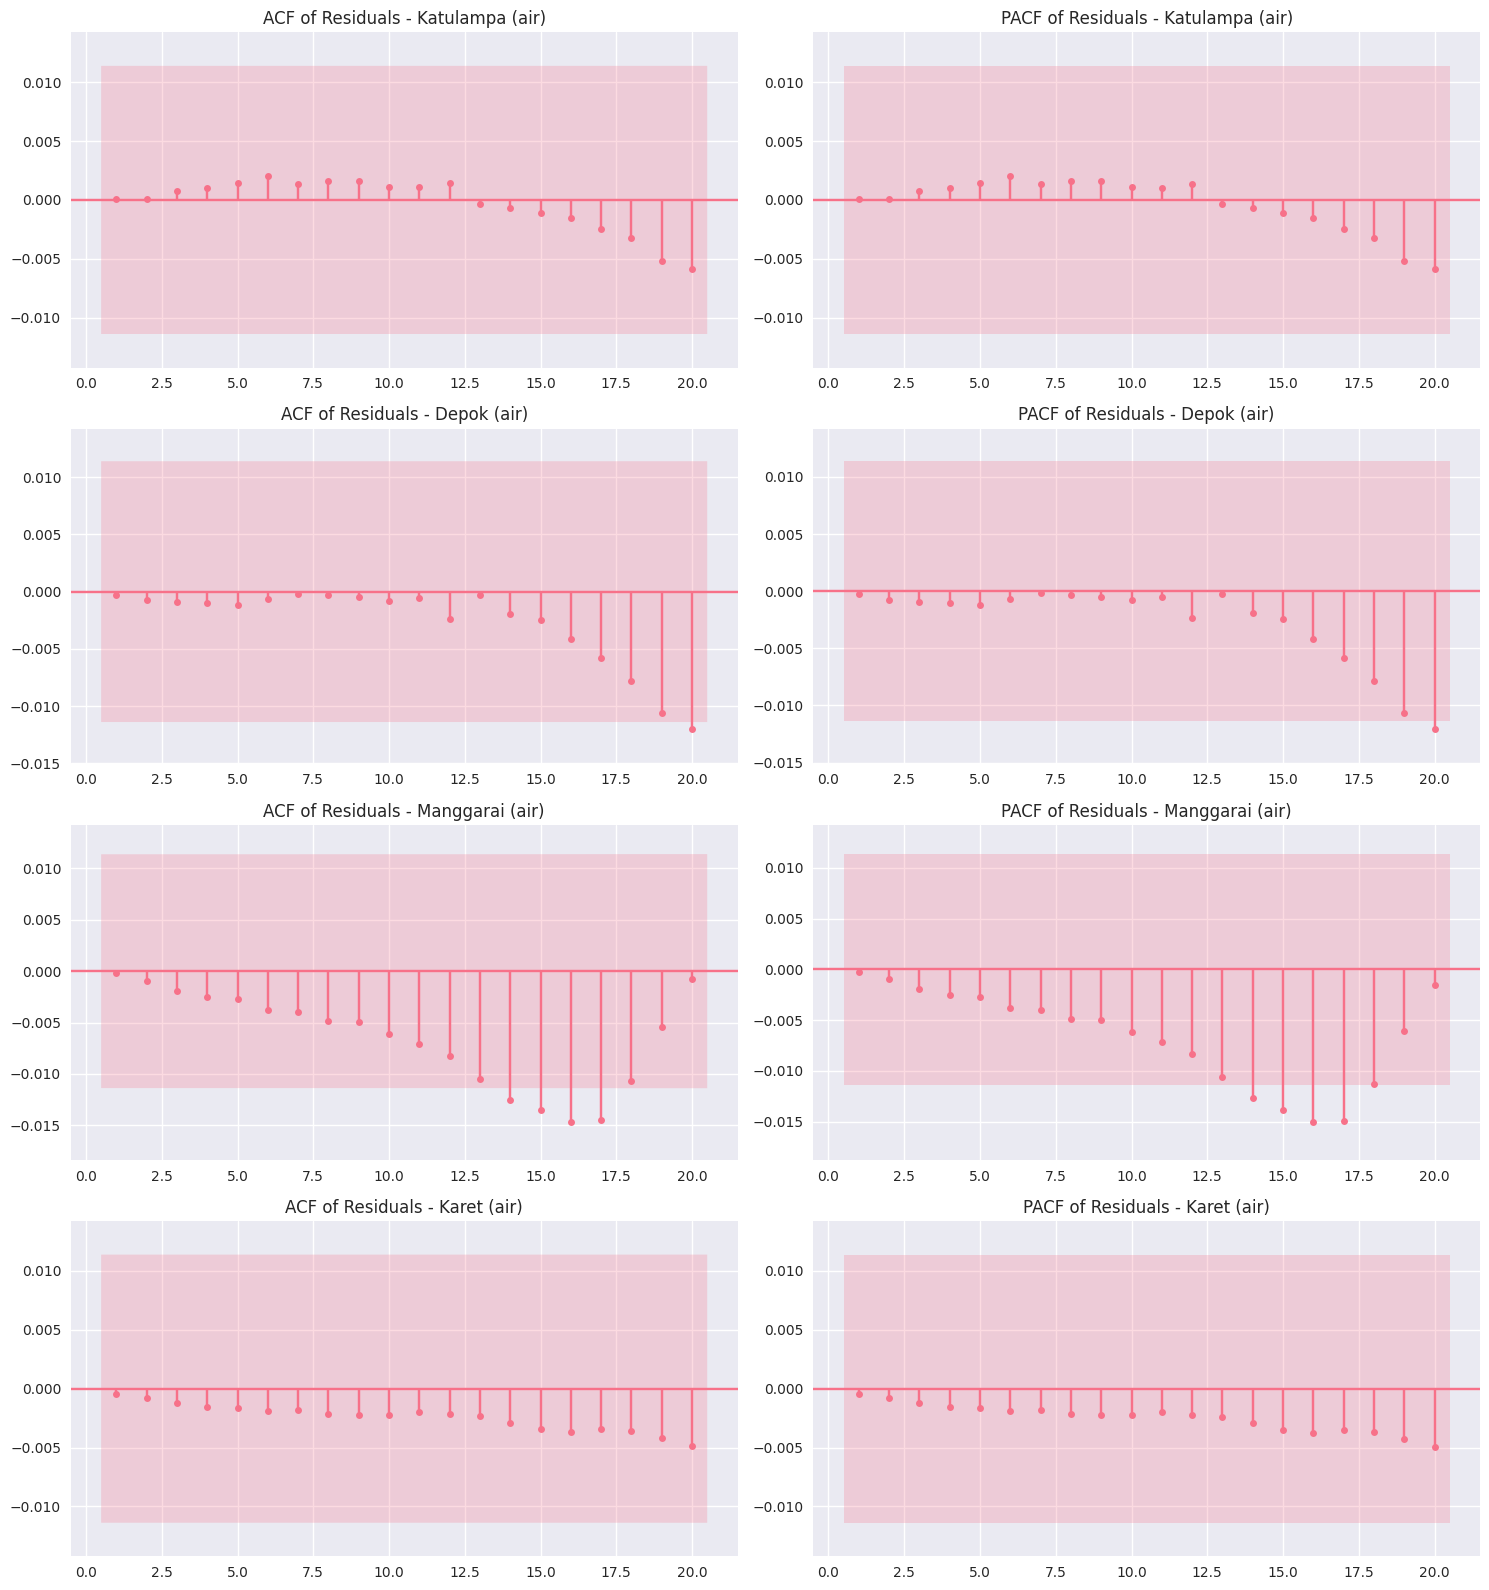


Ljung-Box Test for Residual Autocorrelation:
(Testing if residuals are white noise)
--------------------------------------------------
Katulampa (air) (lag 5): p-value = 0.999798 - White noise
Katulampa (air) (lag 10): p-value = 0.999995 - White noise
Katulampa (air) (lag 15): p-value = 1.000000 - White noise
Depok (air) (lag 5): p-value = 0.999761 - White noise
Depok (air) (lag 10): p-value = 1.000000 - White noise
Depok (air) (lag 15): p-value = 1.000000 - White noise
Manggarai (air) (lag 5): p-value = 0.990576 - White noise
Manggarai (air) (lag 10): p-value = 0.948855 - White noise
Manggarai (air) (lag 15): p-value = 0.142772 - White noise
Karet (air) (lag 5): p-value = 0.998932 - White noise
Karet (air) (lag 10): p-value = 0.999920 - White noise
Karet (air) (lag 15): p-value = 0.999981 - White noise

DETERMINING OPTIMAL q PARAMETER
Analyzing ACF patterns to determine MA order (q):
--------------------------------------------------
Katulampa (air): Significant ACF lags: [], Suggest

In [44]:
# Fit VAR model with optimal lag
optimal_p = 24
var_fitted = model_var.fit(optimal_p)
print(f"VAR({optimal_p}) Model fitted")

# Get residuals
residuals = var_fitted.resid
print(f"Residuals shape: {residuals.shape}")

# Plot ACF and PACF of residuals for each variable
fig, axes = plt.subplots(len(data_y_train_pow.columns), 2, figsize=(15, 4*len(data_y_train_pow.columns)))
if len(data_y_train_pow.columns) == 1:
    axes = axes.reshape(1, -1)

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

for i, col in enumerate(data_y_train_pow.columns):
    # ACF plot
    plot_acf(residuals.iloc[:, i], ax=axes[i, 0], lags=20, alpha=0.05, auto_ylims=True, zero=False)
    axes[i, 0].set_title(f'ACF of Residuals - {col}')
    
    # PACF plot
    plot_pacf(residuals.iloc[:, i], ax=axes[i, 1], lags=20, alpha=0.05, auto_ylims=True, zero=False)
    axes[i, 1].set_title(f'PACF of Residuals - {col}')

plt.tight_layout()
plt.show()

# Ljung-Box test for residual autocorrelation
print("\nLjung-Box Test for Residual Autocorrelation:")
print("(Testing if residuals are white noise)")
print("-" * 50)

for i, col in enumerate(data_y_train_pow.columns):
    # Test at different lags
    for lag in [5, 10, 15]:
        lb_result = acorr_ljungbox(residuals.iloc[:, i], lags=lag, return_df=True)
        p_value = lb_result['lb_pvalue'].iloc[-1]
        print(f"{col} (lag {lag}): p-value = {p_value:.6f} - {'White noise' if p_value > 0.05 else 'Not white noise'}")

# Determine q based on ACF analysis
print(f"\n{'='*80}\nDETERMINING OPTIMAL q PARAMETER\n{'='*80}")

from statsmodels.tsa.stattools import acf

print("Analyzing ACF patterns to determine MA order (q):")
print("-" * 50)

suggested_q = {}
max_q = 5

for i, col in enumerate(residuals.columns):
    # Calculate ACF with confidence intervals
    acf_values = acf(residuals.iloc[:, i], nlags=max_q, alpha=0.05)
    acf_coeffs = acf_values[0]
    acf_conf_int = acf_values[1]
    
    # Find last significant lag
    significant_lags = []
    for lag in range(1, len(acf_coeffs)):
        # Check if ACF is significantly different from 0
        lower_bound = acf_conf_int[lag, 0]
        upper_bound = acf_conf_int[lag, 1]
        
        if not (lower_bound <= 0 <= upper_bound):
            significant_lags.append(lag)
    
    if significant_lags:
        suggested_q[col] = max(significant_lags)
    else:
        suggested_q[col] = 0
        
    print(f"{col}: Significant ACF lags: {significant_lags}, Suggested q: {suggested_q[col]}")

# Take the maximum suggested q across all variables
optimal_q_acf = max(suggested_q.values()) if suggested_q.values() else 0
print(f"\nOptimal q from ACF analysis: {optimal_q_acf}")

VAR(12) Model fitted
Residuals shape: (29650, 4)


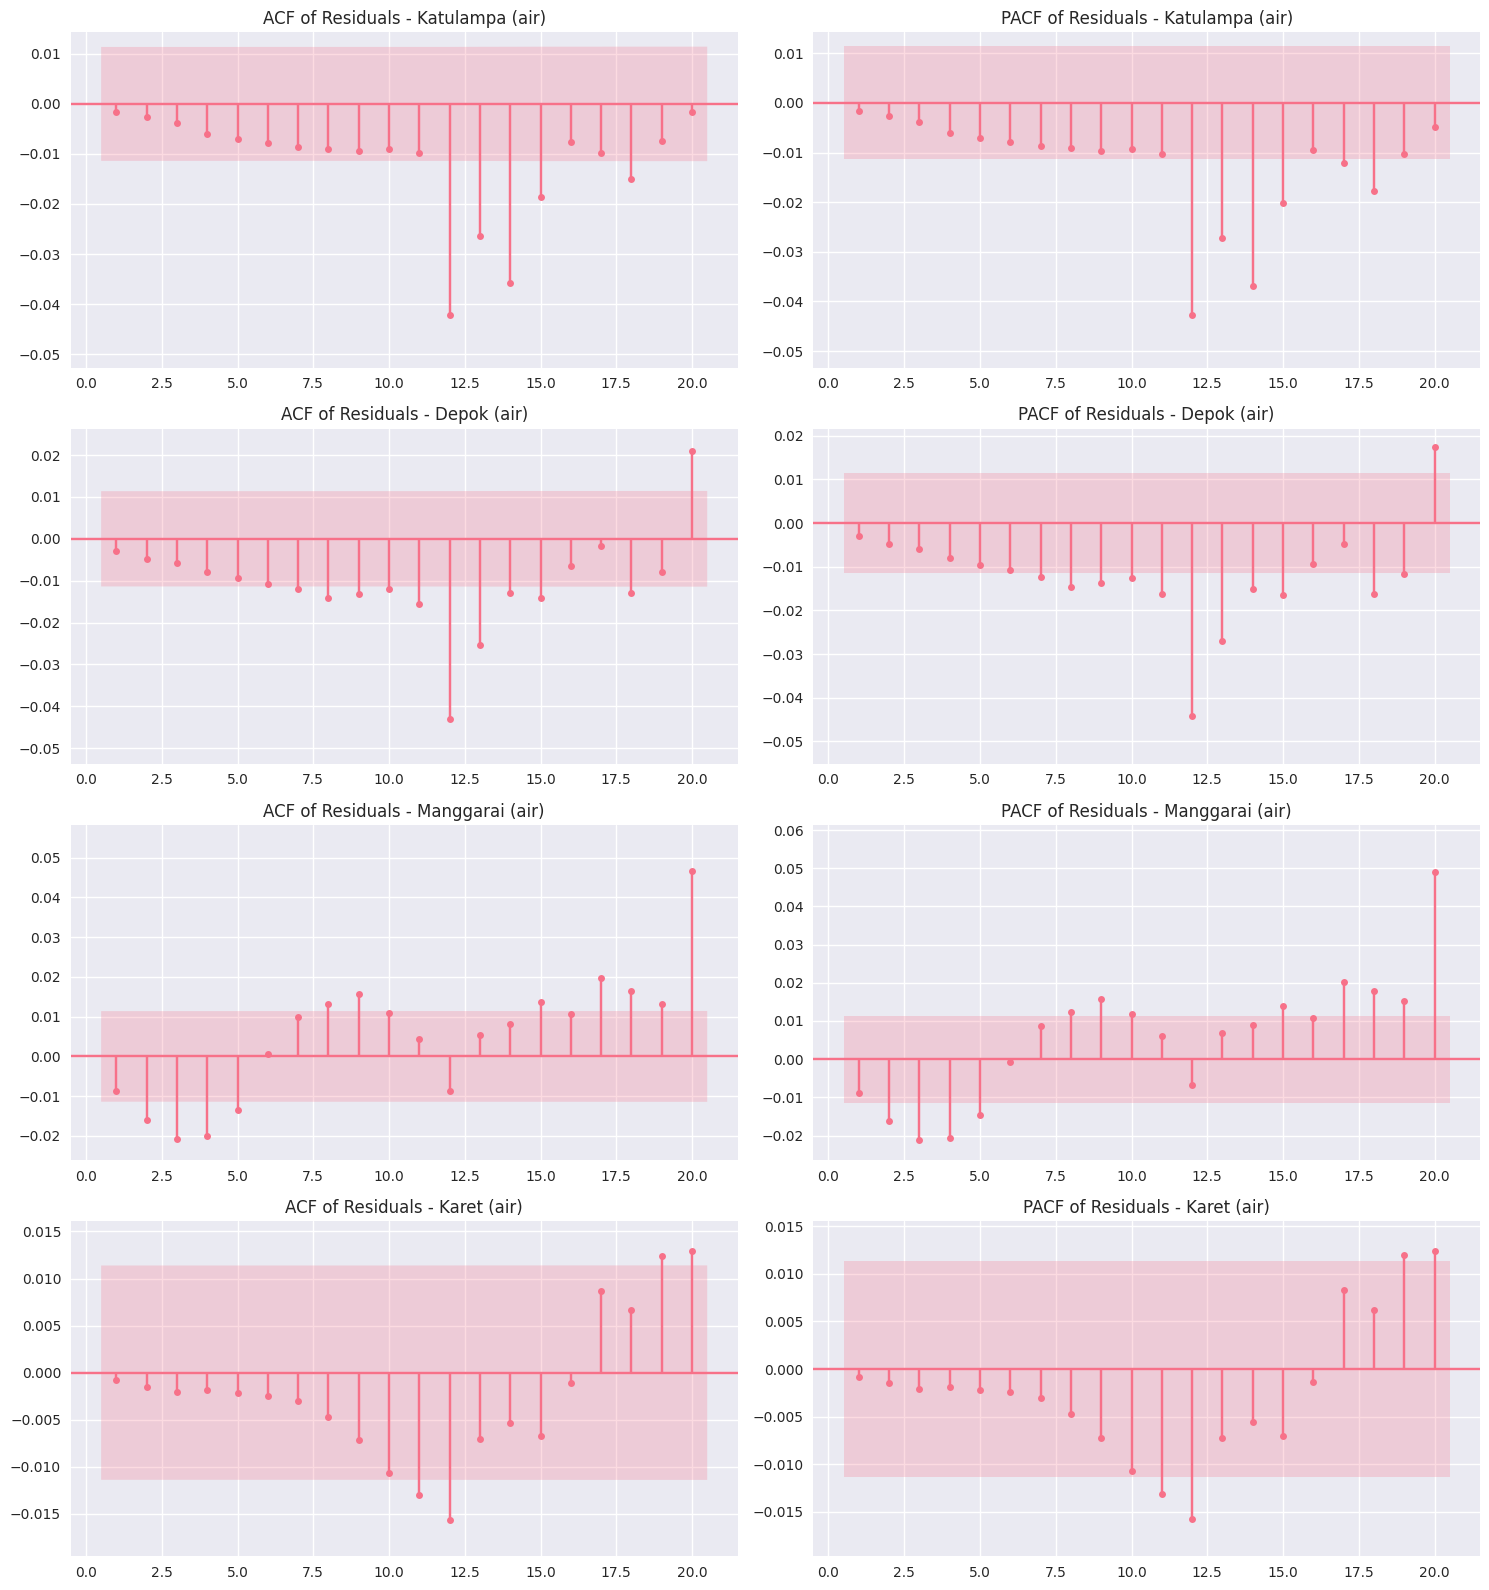


Ljung-Box Test for Residual Autocorrelation:
(Testing if residuals are white noise)
--------------------------------------------------
Katulampa (air) (lag 5): p-value = 0.662637 - White noise
Katulampa (air) (lag 10): p-value = 0.144869 - White noise
Katulampa (air) (lag 15): p-value = 0.000000 - Not white noise
Depok (air) (lag 5): p-value = 0.256001 - White noise
Depok (air) (lag 10): p-value = 0.000991 - Not white noise
Depok (air) (lag 15): p-value = 0.000000 - Not white noise
Manggarai (air) (lag 5): p-value = 0.000000 - Not white noise
Manggarai (air) (lag 10): p-value = 0.000000 - Not white noise
Manggarai (air) (lag 15): p-value = 0.000000 - Not white noise
Karet (air) (lag 5): p-value = 0.993771 - White noise
Karet (air) (lag 10): p-value = 0.776570 - White noise
Karet (air) (lag 15): p-value = 0.099268 - White noise

DETERMINING OPTIMAL q PARAMETER
Analyzing ACF patterns to determine MA order (q):
--------------------------------------------------
Katulampa (air): Significa

In [38]:
# Fit VAR model with optimal lag
optimal_p = 12
var_fitted = model_var.fit(optimal_p)
print(f"VAR({optimal_p}) Model fitted")

# Get residuals
residuals = var_fitted.resid
print(f"Residuals shape: {residuals.shape}")

# Plot ACF and PACF of residuals for each variable
fig, axes = plt.subplots(len(data_y_train_pow.columns), 2, figsize=(15, 4*len(data_y_train_pow.columns)))
if len(data_y_train_pow.columns) == 1:
    axes = axes.reshape(1, -1)

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

for i, col in enumerate(data_y_train_pow.columns):
    # ACF plot
    plot_acf(residuals.iloc[:, i], ax=axes[i, 0], lags=20, alpha=0.05, auto_ylims=True, zero=False)
    axes[i, 0].set_title(f'ACF of Residuals - {col}')
    
    # PACF plot
    plot_pacf(residuals.iloc[:, i], ax=axes[i, 1], lags=20, alpha=0.05, auto_ylims=True, zero=False)
    axes[i, 1].set_title(f'PACF of Residuals - {col}')

plt.tight_layout()
plt.show()

# Ljung-Box test for residual autocorrelation
print("\nLjung-Box Test for Residual Autocorrelation:")
print("(Testing if residuals are white noise)")
print("-" * 50)

for i, col in enumerate(data_y_train_pow.columns):
    # Test at different lags
    for lag in [5, 10, 15]:
        lb_result = acorr_ljungbox(residuals.iloc[:, i], lags=lag, return_df=True)
        p_value = lb_result['lb_pvalue'].iloc[-1]
        print(f"{col} (lag {lag}): p-value = {p_value:.6f} - {'White noise' if p_value > 0.05 else 'Not white noise'}")

# Determine q based on ACF analysis
print(f"\n{'='*80}\nDETERMINING OPTIMAL q PARAMETER\n{'='*80}")

from statsmodels.tsa.stattools import acf

print("Analyzing ACF patterns to determine MA order (q):")
print("-" * 50)

suggested_q = {}
max_q = 5

for i, col in enumerate(residuals.columns):
    # Calculate ACF with confidence intervals
    acf_values = acf(residuals.iloc[:, i], nlags=max_q, alpha=0.05)
    acf_coeffs = acf_values[0]
    acf_conf_int = acf_values[1]
    
    # Find last significant lag
    significant_lags = []
    for lag in range(1, len(acf_coeffs)):
        # Check if ACF is significantly different from 0
        lower_bound = acf_conf_int[lag, 0]
        upper_bound = acf_conf_int[lag, 1]
        
        if not (lower_bound <= 0 <= upper_bound):
            significant_lags.append(lag)
    
    if significant_lags:
        suggested_q[col] = max(significant_lags)
    else:
        suggested_q[col] = 0
        
    print(f"{col}: Significant ACF lags: {significant_lags}, Suggested q: {suggested_q[col]}")

# Take the maximum suggested q across all variables
optimal_q_acf = max(suggested_q.values()) if suggested_q.values() else 0
print(f"\nOptimal q from ACF analysis: {optimal_q_acf}")

In [46]:
varma_model = VARMAX(data_y_train_pow, order=(12, 5))
varma_fitted = varma_model.fit(disp=False, maxiter=1000)

print("VARMA Model fitted successfully!")
print("\nModel Summary:")
print(varma_fitted.summary())

# Model diagnostics
print(f"\n{'='*60}\nMODEL DIAGNOSTICS\n{'='*60}")

# Get residuals
varma_residuals = varma_fitted.resid

# Ljung-Box test on VARMA residuals
print("Ljung-Box Test on The Residuals:")
print("-" * 40)
for i, col in enumerate(data_y_train_pow.columns):
    lb_result = acorr_ljungbox(varma_residuals.iloc[:, i], lags=10, return_df=True)
    p_value = lb_result['lb_pvalue'].iloc[-1]
    print(f"{col}: p-value = {p_value:.6f} - {'Good' if p_value > 0.05 else 'Needs improvement'}")
stat, lillie_pvalue = lilliefors(varma_residuals)
print(f"Lilliefors Test on The Residuals:\n statistic={stat:.4f}, p-value={lillie_pvalue:.4f}")

: 

In [ ]:
varma_model = VARMAX(data_y_train_pow, order=(12, 5), exog=data_x_train)
varma_fitted = varma_model.fit(disp=False, maxiter=1000)

print("VARMA Model fitted successfully!")
print("\nModel Summary:")
print(varma_fitted.summary())

# Model diagnostics
print(f"\n{'='*60}\nMODEL DIAGNOSTICS\n{'='*60}")

# Get residuals
varma_residuals = varma_fitted.resid

# Ljung-Box test on VARMA residuals
print("Ljung-Box Test on The Residuals:")
print("-" * 40)
for i, col in enumerate(data_y_train_pow.columns):
    lb_result = acorr_ljungbox(varma_residuals.iloc[:, i], lags=10, return_df=True)
    p_value = lb_result['lb_pvalue'].iloc[-1]
    print(f"{col}: p-value = {p_value:.6f} - {'Good' if p_value > 0.05 else 'Needs improvement'}")
stat, lillie_pvalue = lilliefors(varma_residuals)
print(f"Lilliefors Test on The Residuals:\n statistic={stat:.4f}, p-value={lillie_pvalue:.4f}")